In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os

base_path = '../results/Meta-Llama-3-1-70B-Instruct-htzs'

custom_name = 'synthetic'
real_name = 'real'

matrices = {
    'en_custom': os.path.join(base_path, f'en/{custom_name}/inter_cluster_distances_en.csv'),
    'en_pretrained': os.path.join(base_path, f'en/{real_name}/inter_cluster_distances_en.csv'),
    'de_custom': os.path.join(base_path, f'de/{custom_name}/inter_cluster_distances_de.csv'),
    'de_pretrained': os.path.join(base_path, f'de/{real_name}/inter_cluster_distances_de.csv'),
    # 'fr_custom': os.path.join(base_path, 'fr/custom/inter_cluster_distances_fr.csv'),
    # 'fr_pretrained': os.path.join(base_path, 'fr/pretrained/inter_cluster_distances_fr.csv'),
}

# INTER
distance_values = {}
for name, path in matrices.items():
    df = pd.read_csv(path)
    df = df.sort_values(['cluster1', 'cluster2']).reset_index(drop=True)
    distance_values[name] = df['inter_distance'].values

# Compute all pairwise correlations
correlations = {}
for name1 in matrices.keys():
    correlations[name1] = {}
    for name2 in matrices.keys():
        corr, _ = stats.pearsonr(distance_values[name1], distance_values[name2])
        correlations[name1][name2] = corr


# INTRA
intra_matrices = {
    'en_custom': os.path.join(base_path, f'en/{custom_name}/intra_cluster_distances_en.csv'),
    'en_pretrained': os.path.join(base_path, f'en/{real_name}/intra_cluster_distances_en.csv'),
    'de_custom': os.path.join(base_path, f'de/{custom_name}/intra_cluster_distances_de.csv'),
    'de_pretrained': os.path.join(base_path, f'de/{real_name}/intra_cluster_distances_de.csv'),
    # 'fr_custom': os.path.join(base_path, 'fr/custom/intra_cluster_distances_fr.csv'),
    # 'fr_pretrained': os.path.join(base_path, 'fr/pretrained/intra_cluster_distances_fr.csv'),
}

intra_distance_values = {}
for name, path in intra_matrices.items():
    df = pd.read_csv(path)
    df = df.sort_values(['cluster']).reset_index(drop=True)
    intra_distance_values[name] = df['avg_intra_distance'].values

intra_correlations = {}
for name1 in intra_matrices.keys():
    intra_correlations[name1] = {}
    for name2 in intra_matrices.keys():
        corr, _ = stats.pearsonr(intra_distance_values[name1], intra_distance_values[name2])
        intra_correlations[name1][name2] = corr

# Convert to DataFrame for easier visualization
corr_df = pd.DataFrame(correlations)
intra_corr_df = pd.DataFrame(intra_correlations)


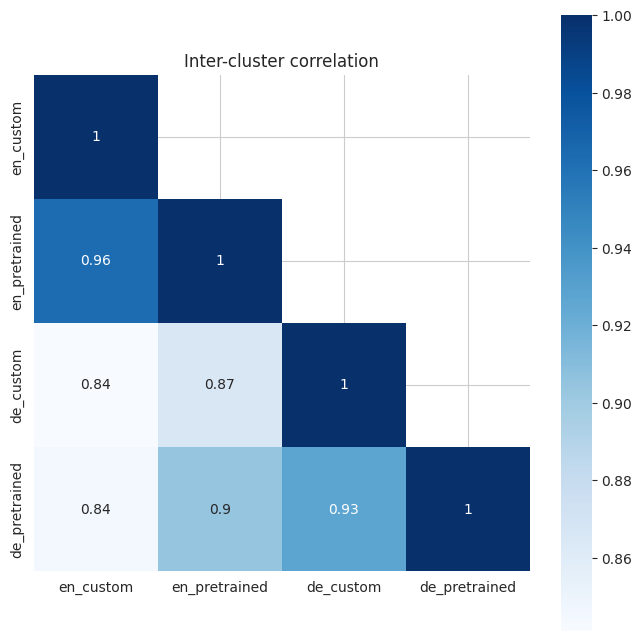

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
matrix = np.triu(corr_df, k=1)

sns.heatmap(corr_df, 
            square=True,  # Make cells square
            annot=True,
            cmap='Blues',
            mask=matrix)
            # vmin=0, vmax=1,  # Fix the range of correlations
            # center=0)
plt.title('Inter-cluster correlation')
plt.savefig('../visuals/inter_correlation.jpg', dpi=300, bbox_inches='tight')

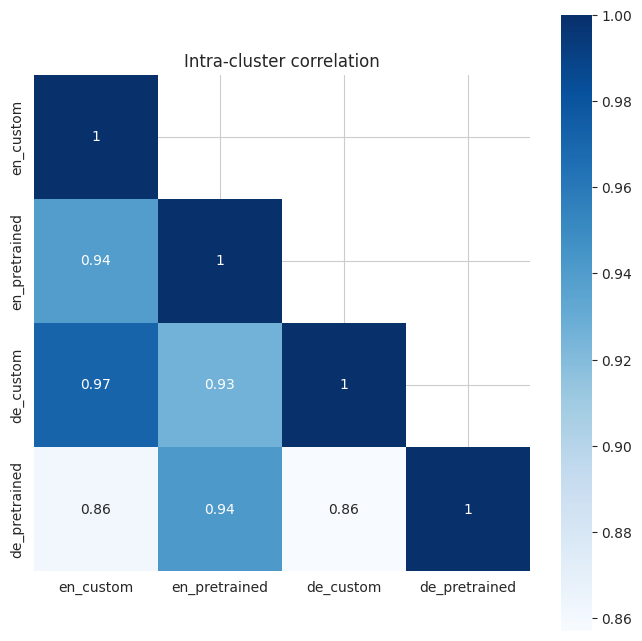

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

sns.heatmap(intra_corr_df, 
            square=True,  # Make cells square
            annot=True,
            cmap='Blues',
            mask=matrix)
            # vmin=-1, vmax=1,  # Fix the range of correlations
            # center=0)
plt.title('Intra-cluster correlation')
plt.savefig('../visuals/intra_correlation.jpg', dpi=300, bbox_inches='tight')

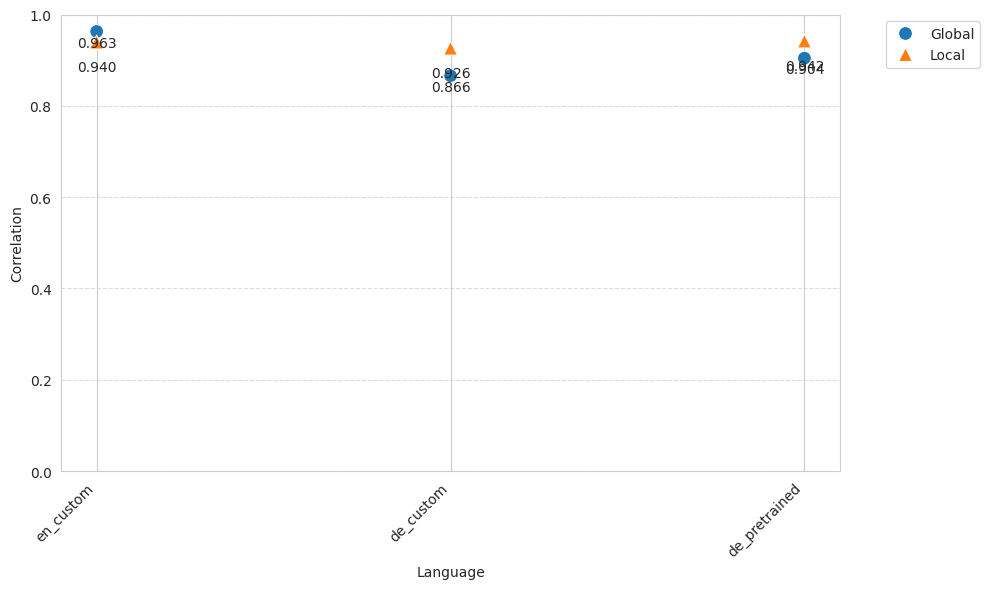

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract correlations from both dataframes
en_pretrained_corrs = corr_df['en_pretrained'].drop('en_pretrained')
intra_en_pretrained_corrs = intra_corr_df['en_pretrained'].drop('en_pretrained')

# Create DataFrames for plotting
plot_data1 = pd.DataFrame({
    'Language': en_pretrained_corrs.index,
    'Correlation': en_pretrained_corrs.values,
    'Type': 'Global'
})

plot_data2 = pd.DataFrame({
    'Language': intra_en_pretrained_corrs.index,
    'Correlation': intra_en_pretrained_corrs.values,
    'Type': 'Local'
})

# Combine the data
plot_data = pd.concat([plot_data1, plot_data2])

# Set up the plot style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create the scatter plot with different markers
scatter = sns.scatterplot(
    data=plot_data,
    x='Language',
    y='Correlation',
    hue='Type',
    style='Type',
    s=100,  # Increase marker size
    markers={'Global': 'o', 'Local': '^'}  # Circle and triangle markers
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels near each point
for type_name, group in plot_data.groupby('Type'):
    for i, (_, row) in enumerate(group.iterrows()):
        offset = 0.02 if type_name == 'Inter-lingual' else -0.04
        scatter.text(i, row['Correlation'] + offset, f'{row["Correlation"]:.3f}', 
                    ha='center', va='bottom' if type_name == 'Global' else 'top')

# Adjust y-axis to show full range of correlations
plt.ylim(0, 1)

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Move legend to a better position
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()